### 1. Start the Environment

In [1]:
from mlagents.envs import UnityEnvironment
import numpy as np

import random
import datetime
import torch
import numpy as np
from collections import deque

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# seaborn
import seaborn as sns
sns.set()

# ddpg agent
from agents.ddpg_multi_agent import MultiAgent


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Reacher Unity environment.

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='../unity_envs/Tennis_Linux_server/Tennis_Linux.x86_64',worker_id=1)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: TennisLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

* Set-up: Two-player game where agents control rackets to bounce ball over a
  net.
* Goal: The agents must bounce ball between one another while not dropping or
  sending ball out of bounds.
* Agents: The environment contains two agent linked to a single Brain named
  TennisBrain. After training you can attach another Brain named MyBrain to one
  of the agent to play against your trained model.
* Agent Reward Function (independent):
  * +0.1 To agent when hitting ball over net.
  * -0.1 To agent who let ball hit their ground, or hit ball out of bounds.
* Brains: One Brain with the following observation/action space.
  * Vector Observation space: 8 variables corresponding to position and velocity
    of ball and racket.
  * Vector Action space: (Continuous) Size of 2, corresponding to movement
    toward net or away from net, and jumping.
  * Visual Observations: None.
* Reset Parameters: One, corresponding to size of ball.
* Benchmark Mean Reward: 2.5

Lets print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = 2
print('Number of agents per arena:', num_agents)

num_parallel_env = len(env_info.agents)//num_agents
print('Number of parallel arenas:', num_parallel_env)

# size of each action
action_size = brain.vector_action_space_size[0]
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents per arena: 2
Number of parallel arenas: 18
Size of each action: 2
There are 36 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.05176163 -1.5
 -0.          0.         -6.14469528  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents*num_parallel_env) # initialize the score (for each agent)
step=0
while True:
    actions = np.random.randn(num_agents*num_parallel_env, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    step+=1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.0005555555431379213


### 4. Find agent indices pairs belonging to same the playing arena

In [6]:
# determine agents ids belonging to the same arena
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents*num_parallel_env) # initialize the score (for each agent)
step=0
same_env_agent_indices = []
while True:
    actions = np.random.randn(num_agents*num_parallel_env, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    step+=1
    if np.sum(dones)==num_agents:
        indices = tuple(np.argwhere(dones).squeeze())
        if indices not in same_env_agent_indices:
            same_env_agent_indices.append(indices)
    
    if len(same_env_agent_indices)==num_parallel_env:
        break
        
print ("Agent tuples belonging to the same playing arena:\n{}".format(same_env_agent_indices))

Agent tuples belonging to the same playing arena:
[(1, 28), (17, 22), (13, 19), (6, 33), (4, 35), (12, 18), (15, 24), (2, 27), (9, 30), (11, 20), (5, 34), (7, 32), (14, 25), (0, 29), (8, 31), (16, 23), (10, 21), (3, 26)]


### 5. Training the agent!

Now it's turn to train an agent to solve the environment!  When training the environment, we have to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# intialize the the ddpg_multi agent
agent = MultiAgent(state_size=env_info.vector_observations.shape[1], 
                    action_size=brain.vector_action_space_size[0],
                    num_agents=num_agents,num_parallel_env=num_parallel_env,
                    agent_indices=same_env_agent_indices,random_seed=0)

model_save_path = '../trained_models/ddpg_multi/'

In [8]:
# check the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


Lets target a score of 2.5 for solving this environment
`target_score=2.5`

In [10]:
# train function for ddpg agent
def ddpg_multi_train(agent,n_steps=int(5e3),max_t=1000,target_score=2.5,PRINT_EVERY=50):
    
    # logs for storing agent rewards during training
    episode_rewards_window = deque(maxlen=100)
    episode_rewards = []
    online_rewards = np.zeros(num_agents*num_parallel_env)
    
    # reset the environment and the agent
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    agent.reset()
    
    for step in range(1, n_steps+1):
        # compute agent actions
        actions = agent.act(states)
        
        # feed the agent actions to the environment
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = np.array(env_info.rewards)
        dones = np.array(env_info.local_done)

        # take agent update step
        agent.step(states, actions, rewards, next_states, dones)
        
        # update current state and online rewards
        states = next_states
        online_rewards += rewards
        
        # update episode rewards log if any agent is done
        for i, terminal in enumerate(dones):
            if dones[i]:
                episode_rewards.append(online_rewards[i])
                episode_rewards_window.append(online_rewards[i])
                online_rewards[i] = 0
        
        # the tennis unity env has a max runtime step count of 5000,
        # so reset the env from time to time to prevent running into an error
        if step % max_t == 0:
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            agent.reset()
        
        # print training progress
        if step % PRINT_EVERY == 0:
            # save the trained models
            for i in range(agent.num_agents):
                torch.save(agent.agents[i].actor_local.state_dict(), "{}ddpg_multi_actor_{}.pth".format(model_save_path,i))
                torch.save(agent.agents[i].critic_local.state_dict(), "{}ddpg_multi_critic_{}.pth".format(model_save_path,i))
                
            # print progress
            print('Step: {}\t Average reward: {:.4f}\t Current Reward: {:.2f}'.format(step,
                                                                np.mean(episode_rewards_window),episode_rewards[-1]))
        
        # check if the environment is solved
        if np.mean(episode_rewards_window)>target_score:
            # save the trained models
            for i in range(agent.num_agents):
                torch.save(agent.agents[i].actor_local.state_dict(), "{}ddpg_multi_actor_{}.pth".format(model_save_path,i))
                torch.save(agent.agents[i].critic_local.state_dict(), "{}ddpg_multi_critic_{}.pth".format(model_save_path,i))
                
            
            # print progress
            print ("\nEnvironment solved in {} episodes! ... Avg Reward: {:.2f}".format(len(episode_rewards)//num_parallel_env*num_agents -100,
                                                                                        np.mean(episode_rewards_window)))
            break
            
    return episode_rewards

In [11]:
# train the ddpg_multi agent
scores = ddpg_multi_train(agent,n_steps=int(1e5),PRINT_EVERY=1000)

/home/jsingh/anaconda3/envs/reacher/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Step: 1000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 2000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 3000	 Average reward: -0.0050	 Current Reward: 0.00
Step: 4000	 Average reward: -0.0050	 Current Reward: 0.00
Step: 5000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 6000	 Average reward: -0.0049	 Current Reward: -0.01
Step: 7000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 8000	 Average reward: -0.0049	 Current Reward: -0.01
Step: 9000	 Average reward: -0.0050	 Current Reward: 0.00
Step: 10000	 Average reward: -0.0041	 Current Reward: 0.00
Step: 11000	 Average reward: -0.0020	 Current Reward: -0.01
Step: 12000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 13000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 14000	 Average reward: -0.0050	 Current Reward: 0.00
Step: 15000	 Average reward: -0.0050	 Current Reward: -0.01
Step: 16000	 Average reward: -0.0049	 Current Reward: -0.01
Step: 17000	 Average reward: 0.0240	 Current Reward: -

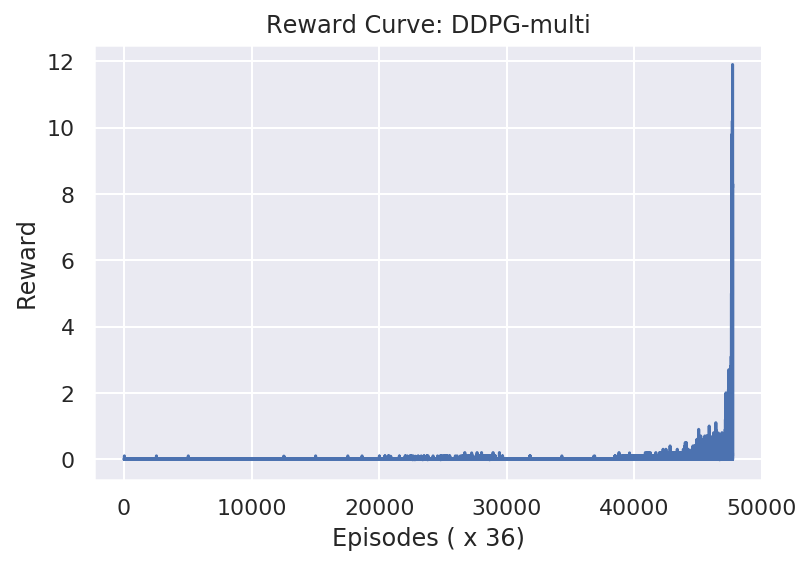

In [12]:
# plot the reward curve
fig = plt.figure()
plt.plot(scores)
plt.ylabel('Reward')
plt.xlabel('Episodes ( x {})'.format(num_parallel_env*num_agents))
plt.title('Reward Curve: DDPG-multi')
plt.savefig('../images/reward_curve-ddpg_multi.png',dpi=300)
plt.show()

### 6. Watch the trained agent!

In [14]:
# # uncomment this cell to load pretrained model weights
# agent = MultiAgent(state_size=env_info.vector_observations.shape[1], 
#                 action_size=brain.vector_action_space_size[0],
#                 num_agents=num_agents,num_parallel_env=num_parallel_env,
#                 agent_indices=same_env_agent_indices,random_seed=0)

# for i in range(agent.num_agents):
#     agent.agents[i].actor_local.load_state_dict(torch.load("{}ddpg_multi_actor_{}.pth".format(model_save_path,i),
#                                                     map_location=device))

In [15]:
# logs for storing reward for the first agent during training
online_reward = 0

# agent id for computing reward
agent_id = np.random.randint(low=0,high=num_agents*num_parallel_env)

# reset the environment and the agent
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
agent.reset()

while True:
    # compute agent actions
    actions = agent.act(states,add_noise=False)

    # feed the agent actions to the environment
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = np.array(env_info.rewards)
    dones = np.array(env_info.local_done)                        

    # update current state and online rewards
    states = next_states
    online_reward += rewards[agent_id]

    # update episode rewards log if any agent is done
    if dones[agent_id]:
        break

print ("Agent id: {}\t Episode reward {:.2f}".format(agent_id,online_reward))

Agent id: 9	 Episode reward 2.60


In [16]:
# close the unity environment
env.close()